# Defect Binary Classification
![System Test Engineering Logo](../figures/logo_fhj_stm.jpg)<br>
---

**A Component my System Test Engineering Master's Thesis**  
**FH JOANNEUM - University of Applied Sciences**

---

**Author:** Luis Kraker  
**Supervisor:** DDr. Gudrun Schappacher-Tilp  
**Date:** 28<sup>th</sup> March, 2024    

---

## Setup

In [1]:
# Imports
import importlib
import os

import tensorflow as tf

import source.load_raw_data.kaggle_dataset as kaggle_dataset
from source.model.helpers.image_classifier_visualizer import ImageClassifierVisualizer
from source.model.helpers.image_classifiers_trainer import ImageClassifiersTrainer
from source.preprocessing.image_preprocessor import ImagePreprocessor
import source.preprocessing.preprocessing_steps as steps
from source.load_raw_data.save_images_from_tf_dataset import save_images_from_tf_dataset

c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\tensorflow\python\framework\dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [2]:
OUTPUT_DIR = os.path.join(os.path.curdir,  '..', '..', '..', '..', 'outputs', 'defect_binary_classification')
IMAGES_DIR = os.path.join(OUTPUT_DIR, 'images')
RESULTS_DIR = os.path.join(OUTPUT_DIR, 'results')

In [11]:
# Load Dataset 
image_datasets = {}
image_datasets['NO_DEFECT'] = kaggle_dataset.get_tf_dataset_with_category_zero()
image_datasets = kaggle_dataset.get_tf_datasets_for_each_category()


In [28]:
categories = list(image_datasets.keys())

In [5]:
# Count Elements
def count_elements_in_datasets(datasets):
    for category, dataset in datasets.items():
        count = 0
        for _ in dataset:
            count += 1
        print(f"Category: {category}, Number of Images: {count}")

count_elements_in_datasets(image_datasets)

Category: NO_DEFECT, Number of Images: 10
Category: MISSING_HOLE, Number of Images: 115
Category: MOUSE_BITE, Number of Images: 115
Category: OPEN_CIRCUIT, Number of Images: 116
Category: SHORT, Number of Images: 116
Category: SPUR, Number of Images: 115
Category: SPURIOUS_COPPER, Number of Images: 116


## Preprocessing

In [13]:
# Upsample in 'NO_DEFECT' dataset
no_defect_dataset = image_datasets['NO_DEFECT']
no_defect_dataset_repeated = no_defect_dataset.repeat(11)
no_defect_dataset_partial = no_defect_dataset.take(5)
image_datasets['NO_DEFECT'] = no_defect_dataset_repeated.concatenate(no_defect_dataset_partial)

In [ ]:

# Count elements again
count_elements_in_datasets({'NO_DEFECTS': image_datasets['NO_DEFECT']})


In [17]:
# Print Dimensions Statistics
def print_dimensions_statistics(datasets):
    for category, dataset in datasets.items():
        total_images = 0
        sum_dims = tf.constant([0, 0], dtype=tf.int32)

        for image, _ in dataset:
            img_shape = tf.shape(image)
            sum_dims += img_shape[:2]
            total_images += 1

        mean_dims = sum_dims / total_images

        sum_squared_diff = tf.constant([0, 0], dtype=tf.float32)
        for image, _ in dataset:
            img_shape = tf.shape(image)
            squared_diff = tf.square(tf.cast(img_shape[:2], tf.float32) - tf.cast(mean_dims, tf.float32))
            sum_squared_diff += squared_diff

        stddev_dims = tf.sqrt(sum_squared_diff / total_images)
        aspect_ratio = mean_dims[0] / mean_dims[1]

        print(f"Category: {category}, Mean: {mean_dims.numpy()}, STDDev: {stddev_dims.numpy()}, Aspect Ratio: {aspect_ratio}")

print_dimensions_statistics(image_datasets)

Category: MISSING_HOLE, Mean: [2138.43478261 2779.2173913 ], STDDev: [305.73615 266.61545], Aspect Ratio: 0.7694377522605674
Category: MOUSE_BITE, Mean: [2138.43478261 2779.2173913 ], STDDev: [305.73615 266.61545], Aspect Ratio: 0.7694377522605674
Category: OPEN_CIRCUIT, Mean: [2137.37931034 2774.56896552], STDDev: [304.62576 270.10355], Aspect Ratio: 0.7703464346745378
Category: SHORT, Mean: [2139.96551724 2779.98275862], STDDev: [304.8577 265.5907], Aspect Ratio: 0.7697765428959495
Category: SPUR, Mean: [2138.43478261 2779.2173913 ], STDDev: [305.73615 266.61545], Aspect Ratio: 0.7694377522605674
Category: SPURIOUS_COPPER, Mean: [2137.37931034 2774.56896552], STDDev: [304.62576 270.10355], Aspect Ratio: 0.7703464346745378
Category: NO_DEFECT, Mean: [2157.86956522 2700.47826087], STDDev: [256.01825 275.43066], Aspect Ratio: 0.7990694079953633


In [14]:
tf.random.set_seed(42)

preprocessor = ImagePreprocessor()

pipeline = [
    steps.ShapeResizer(desired_shape=(2000, 2600)),
    steps.RandomRotator(angle_range=(-3,3)),
    steps.RandomFlipper(flip_direction='horizontal'),
    steps.RandomFlipper(flip_direction='vertical'),
]

preprocessor.set_pipe(pipeline)
processed_datasets = {}
for category, dataset in image_datasets.items():
    processed_datasets[category] = preprocessor.process(dataset)


In [ ]:
from source.load_raw_data.save_images_from_tf_dataset import save_images_from_tf_dataset

save_images_from_tf_dataset(processed_datasets['NO_DEFECT'].take(15), os.path.join(IMAGES_DIR, 'no_defect'))

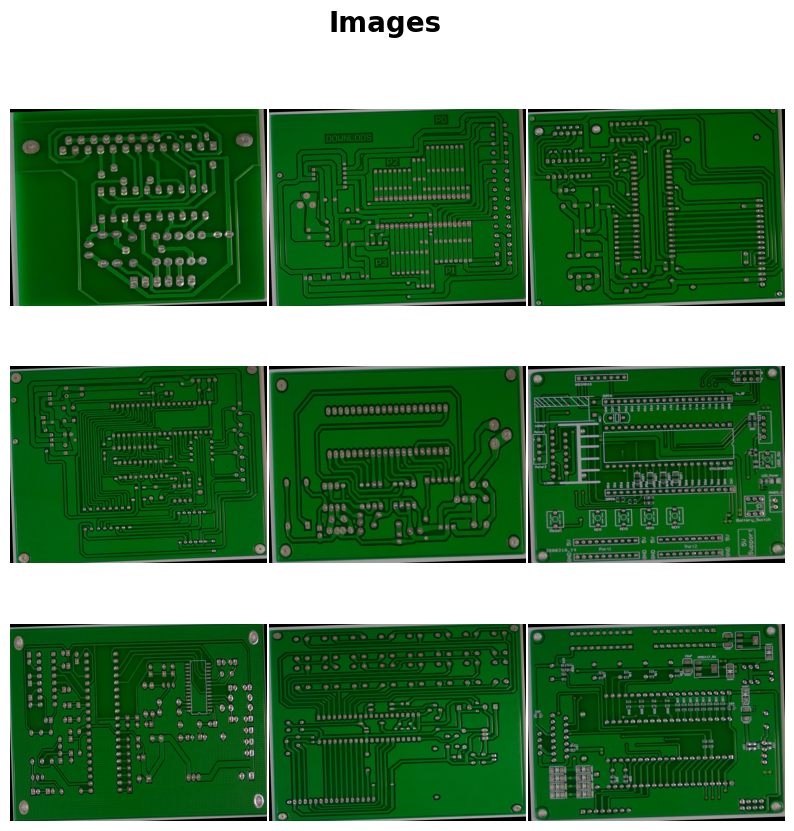

In [ ]:
from source.utils.pcb_visualization import PCBVisualizerforTF as PCBVisualizer
from source.load_raw_data.unpack_tf_dataset import unpack_tf_dataset

no_defect_dataset = unpack_tf_dataset(processed_datasets['NO_DEFECT'])[0]
visualizer = PCBVisualizer()
visualizer.plot_images(no_defect_dataset)

In [ ]:
visualizer = ImageClassifierVisualizer(categories)
visualizer.plot_images(processed_datasets['NO_DEFECT'], n_cols=3, n_rows=3)

## Make Data Digestable for Model

In [18]:
# Concat dataset of category 0 with the rest
concatenated_dataset = {}
for category, dataset in processed_datasets.items():
    if category == 'NO_DEFECT':
        continue
    concatenated_dataset.update({category: dataset.concatenate(processed_datasets['NO_DEFECT'])})

# Shuffle the datasets
for category, dataset in concatenated_dataset.items():
    concatenated_dataset[category] = dataset.shuffle(1000)

# Split the datasets
train_datasets = {}
validation_datasets = {}
split_factor = 0.7

for category, dataset in concatenated_dataset.items(): 
    # get length of dataset  
    dataset_length = dataset.reduce(0, lambda x, _: x + 1).numpy()
    train_length = int(dataset_length * split_factor)
    train_datasets[category] = dataset.take(train_length)
    validation_datasets[category] = dataset.skip(train_length)

# print sizes of train and validation datasets
for category, dataset in train_datasets.items():
    print(f"Category: {category}, Train Size: {dataset.reduce(0, lambda x, _: x + 1).numpy()}")
    break

Category: MISSING_HOLE, Train Size: 161


In [23]:
categories.remove('NO_DEFECT')

In [49]:
complete_datasets = {}

def one_hot_encode(image, label):
    label = tf.one_hot(label, len(categories))
    label = tf.expand_dims(label, axis=-1)
    label = tf.transpose(label)
    return image, label

for category, train_dataset in train_datasets.items():
    complete_datasets[category] = (train_dataset.map(one_hot_encode), validation_datasets[category].map(one_hot_encode))

In [48]:
# Check shape of label
for category, (train_dataset, validation_dataset) in complete_datasets.items():
    for image, label in train_dataset:
        print(f"Category: {category}, Label Shape: {label.shape}")
        break
break

Category: MISSING_HOLE, Label Shape: (7, 1)


KeyboardInterrupt: 

## Model 1


In [50]:
model = tf.keras.Sequential([
    tf.keras.layers.MaxPooling2D((5, 5), input_shape=(2000, 2600, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(categories), activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
import source.model.helpers.image_classifiers_trainer as icv
importlib.reload(icv)

defect_categories = list(complete_datasets.keys())

trainer = icv.ImageClassifiersTrainer(category_names=categories, group_names=defect_categories)
trainer.load_model(model)
trainer.fit_all(complete_datasets, epochs=5)


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_9/max_pooling2d_9/MaxPool defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\43664\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\43664\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\43664\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\43664\AppData\Local\Temp\ipykernel_22504\3832915380.py", line 8, in <module>

  File "C:\MEIN_PLATZ\Git\pcb-defect-detection\source\model\helpers\image_classifiers_trainer.py", line 99, in fit_all

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\training.py", line 589, in __call__

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\keras\src\layers\pooling\base_pooling2d.py", line 84, in call

tensor_in_shape must have 2 spatial dimensions. 3 0
	 [[{{node sequential_9/max_pooling2d_9/MaxPool}}]] [Op:__inference_train_function_220542]

In [ ]:
histories = trainer.plot_histories()